# [LAB-10] 7.  대응표본 t-검정 (paired t-test)

- 표본의 각 사례마다 대응하는 2개의 관측치를 통해 판단
- 한 집단에 어떤 작용이 가해졌을 때에 대한 before, after를 비교
- ‘related samples t-test’ 또는 ’paired samples t-test’로 부른다.
- statannotations 패키지가 seaborn 0.12 이하 버전만 지원한다. 현재 seaborn의 최
신 버전은 0.13 

| 표본 유형 | 정규성 | 등분산성 | t-test 선택 |
| -------- | ------ | ------- | ----------- |
| 단일표본 | 충족 | - | One-sample t-test |
| `` | 불충족 | - | Wilcoxon signed-reank test |
| 독립표본 | 충족 | 충족 | Student's independent t-test |
| `` | 충족 | 불충족 | Welch's t-test |
| `` | 불충족 | - | Mann-Whitney U test |
| 대응표본(쌍체표본) | 충족 | - | Paired t-test |
| `` | 불충족 | - | Wilcoxon signed-reank test |

- 단일표본, 대응표본엔 등분산성 개념 없음
- 정규성에서 처음 충족 안되면 로그변환 해보고, 그래도 충족 안됬을 때 선택해야 하는 t-test라고 생각하면 됨.

## #01. 준비작업

### 1. 패키지 참조:

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 대응표본 가설검정용 패키지:
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene, ttest_rel, mannwhitneyu
from statannotations.Annotator import Annotator

### 2. 그래프 초기화:

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

## #02. 예제(1) - 사슴의 다리길이 비교

사슴의 왼쪽 앞다리와 왼쪽 뒷다리의 길이를 측정한 자료를 통해 두 다리의 길이(cm)가 같은지
다른지 알고 싶다.
이 경우 한 사슴에 대하여 두 다리 길이를 측정하였으므로 사슴은 독립이지만 한 마리의 사슴의
일부인 두 다리는 독립이 아니다.

### 1. 데이터 가져오기:

In [3]:
origin = load_data('deer')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/deer.xlsx
[desc] 사슴의 왼쪽 앞다리와 왼쪽 뒷다리의 길이를 측정한 자료 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (10, 3)
열 갯수: 3
행 갯수: 10

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   사슴      10 non-null     int64
 1   앞다리     10 non-null     int64
 2   뒷다리     10 non-null     int64
dtypes: int64(3)
memory usage: 372.0 bytes
None


,사슴,앞다리,뒷다리
0,1,138,142
1,2,136,140
2,3,147,144
3,4,139,144
4,5,143,142


### 2. 신뢰구간 확인:

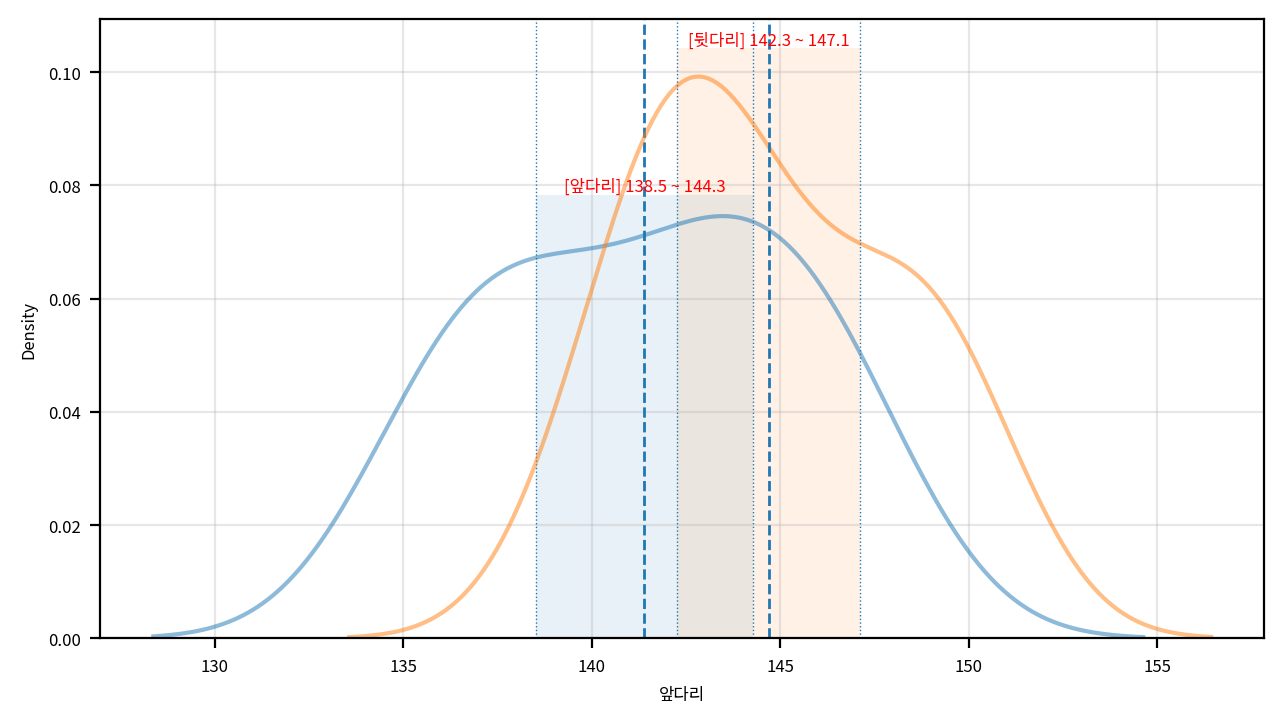

In [4]:
data = origin[['앞다리', '뒷다리']]  # 확인할 데이터 (컬럼단위)

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for c in data.columns:
    # 2) KDE plot 그리기:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 2-1) 신뢰구간용 기본변수:
    max = data[c].max()                        # 최대값
    dof = len(data[c]) - 1                     # 자유도
    clevel = 0.95                           # 신뢰수준
    sp_mean = data[c].mean()                   # 표본평균
    sp_std = data[c].std() # default: ddof=1   # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차

    # 2-2) 신뢰구간 x값:
    cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

    ax.axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
    ax.axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

    # 2-3) 신뢰구간 y값:
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    # 2-4) 평균선 표시:
    ax.axvline(sp_mean, linestyle="--", linewidth=1)

    # 2-5) 텍스트 그리기 (statAnnotator 기능):
    ax.text(x = cmin + (cmax-cmin)/2,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment = "center",
            verticalalignment = "bottom",
            fontdict = {"size": 6, "color": "red"})

# 3) 그래프 꾸미기: 
ax.grid(True, alpha=0.3)     # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

### 3. 가설검정의 가정 확인:

In [5]:
data = origin[['앞다리', '뒷다리']]     # 검사 원하는 데이터 추출

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    s, p = normaltest(data[c])

    normalize = p > 0.05
    report.append({
        "fields": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 변수가 두개 이상일 때 확인해야될 등분산성:
if len(data.columns) > 1:
    # 정규성 충족할 때 등분산성 검정방법:
    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*data.values.T) # 모든 컬럼의 데이터 한번에
    # 정규성 충족 못할 때 등분산성 검정법:
    else:
        n = "Levene's"
        s, p = levene(*data.values.T, center='median')
        # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨
    
    report.append({
        "fields": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
앞다리,1.824001,0.401720,True
뒷다리,1.376960,0.502339,True
Bartlett,0.340678,0.559438,True


### 4. t-test: 사슴의 앞다리랑 뒷다리의 길이가 다른지 검정

In [ ]:
# 독립표본의 t-test에선 target값 필요없음

# 귀무: 차이가 없다, 대립: 차이가 있다
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'], alternative='two-sided')
"statistic:{0:.3f}, p-value:{1:.3f}, {2}가설 채택".format(s, p, '대립' if p<=0.05 else '귀무')

'statistic:-3.414, p-value:0.008, 대립가설 채택'

### 5. t-test: 앞다리가 뒷다리보다 더 긴지 검정: 

In [8]:
# 귀무: 앞다리가 더 길지 않다, 대립: 앞다리가 더 길다
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'], alternative='greater')
"statistic:{0:.3f}, p-value:{1:.3f}, {2}가설 채택".format(s, p, '대립' if p<=0.05 else '귀무')

'statistic:-3.414, p-value:0.996, 귀무가설 채택'

### 6. t-test: 앞다리가 뒷다리보다 더 짧은지 검정 :

In [9]:
# 귀무: 앞다리가 더 짧지 않다, 대립: 앞다리가 더 짧다
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'], alternative='less')
"statistic:{0:.3f}, p-value:{1:.3f}, {2}가설 채택".format(s, p, '대립' if p<=0.05 else '귀무')

'statistic:-3.414, p-value:0.004, 대립가설 채택'

### 7. 가설검정 시각화:

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

앞다리 vs. 뒷다리: t-test paired samples, P_val:7.703e-03 t=-3.414e+00


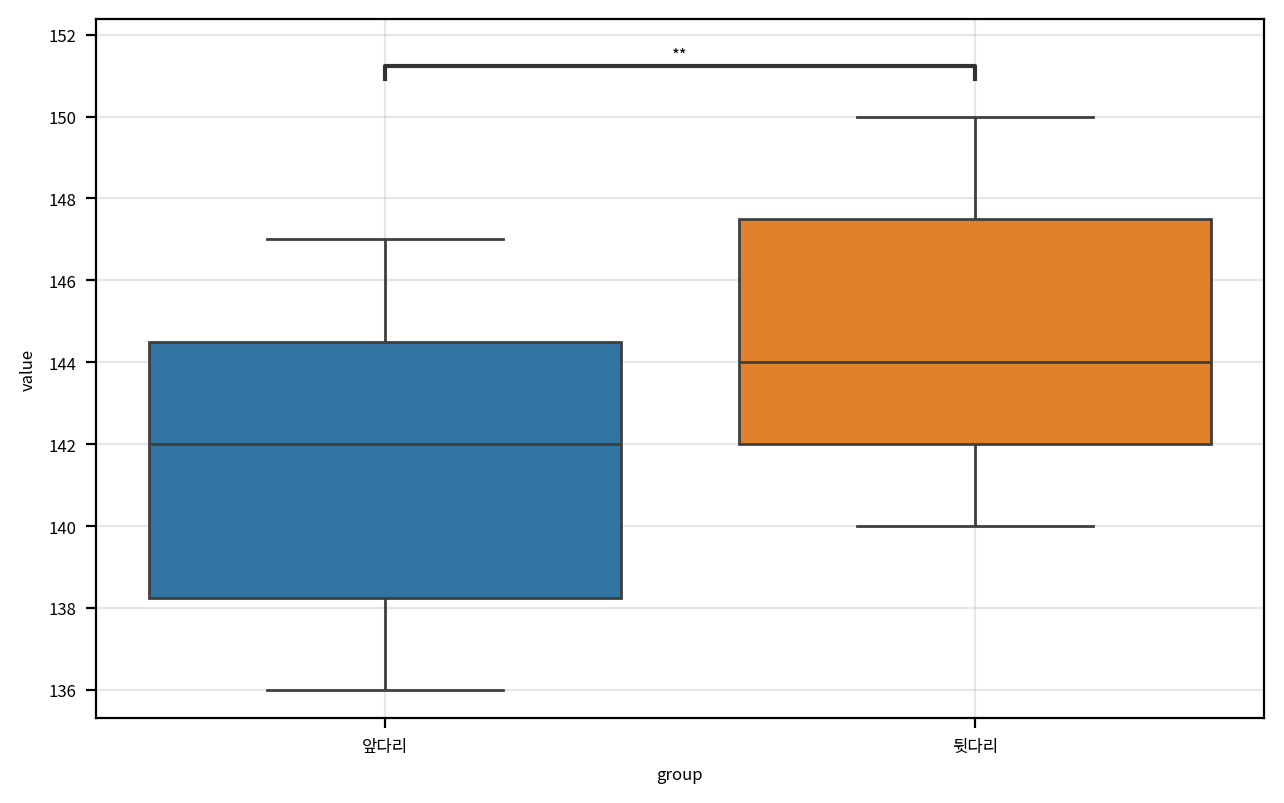

In [12]:
# 검정할 데이터 필드 이름:
fields = ['앞다리', '뒷다리']

# 검정방법: 
# 't-test_ind', 't-test_paired', 't-test_welch', 'Mann-Whitney', 
# 'Mann-Whitney-gt', 'Mann-Whitney-ls', 'Levene', 'Wilcoxon', 'Kruskal'
test_method = 't-test_paired'

# 0) 데이터 전처리 (hue 쓰기 위해 melt로 재배치)
df = melt(origin[fields], value_vars = fields,
          var_name='group', value_name='value') #✅: hue용
df

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 800             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) boxplot 그래프 그리기:
sb.boxplot(data = df, hue = 'group', x = 'group', y = 'value')

annotator = Annotator(ax, data=df, x = 'group', y = 'value',
                      pairs = [fields])   # hue종류(pairs는 2차원임!)
annotator.configure(test = test_method)         # 환경설정
annotator.apply_and_annotate()                   # 적용 및 표시

# 3) 그래프 꾸미기: 
ax.grid(True, alpha=0.3)                # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()                      # 여백 제거
plt.show()                              # 그래프 화면 출력
plt.close()                             # 그래프 작업 종료

## #03. 예제(2) - 자동차 첨가제가 주행거리에 미치는 영향

다섯 종류의 새 차에 대하여 같은 종류의 차 두 대 중에서 한 대를 랜덤하게 선택하여 첨가제를 사
용하고, 다른 한 대에는 첨가제를 사용하지 않고 같은 운전자가 같은 장소에서 운전한 결과 다음
과 같은 자료를 얻었다.
첨가제를 사용하면 주행거리가 늘어난다고 할 수 있는지 유의수준 5%에서 검정하여 보라.

그룹A : 첨가제를 사용한 경우, 그룹B : 첨가제를 사용하지 않은 경우

### 1. 데이터 가져오기:

### 2. 신뢰구간 확인:

### 3. 가설검정의 가정 확인:

> 데이터가 정규성을 만족하지만 등분산성은 만족하지 않는다.

### 4. t-검정: 두 그룹의 주행거리가 차이가 있는지:

### 5. t-검정: 그룹A의 주행거리가 그룹B의 주행거리보다 짧은지:

### 6. t-검정: 그룹A의 주행거리가 그룹B의 주행거리보다 긴지:

### 7. 가설검정 시각화: